## Where everything comes from

Data were collected on April 22, 2020. The source files can be found on the Google Drive:

   * Our raw data: **penn-2020-04-22/PrincetonFlowMeter_simtest.out**
   * NM3 data: **penn-2020-04-22/200422_princetonmonitor.txt**
   * ASL data: **ASL Files/***

Our timeseries data, **penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv**, were derived using

```bash
./device_json_to_timeseries.py penn-2020-04-22/PrincetonFlowMeter_simtest.out --start-time-at-zero > penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv
```

Our breaths data, **penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv**, were derived using

```bash
./timeseries_to_breaths.py penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv > penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv
```

In [1]:
import re
import string
import numpy as np

import json
import matplotlib.pyplot as plt
import scipy.signal
import scipy.integrate

import pandas as pd

## Reading in our data

In [2]:
our_timeseries = pd.read_csv("../penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv")
our_timeseries.columns = our_timeseries.columns.str.strip()
our_timeseries

,time (sec),pressure (cm H2O),flow (L/min),volume (mL),minbias volume (mL)
0,0.000,-0.2040,-0.7198,368.0971,0.0000
1,0.020,-0.1749,1.3485,368.2012,0.1048
2,0.040,-0.1615,1.0696,368.6004,0.5078
3,0.060,-0.1962,0.0000,368.7713,0.6860
4,0.080,-0.1898,1.3485,368.9862,0.9108
...,...,...,...,...,...
140440,2813.227,-0.0410,1.5894,392.3519,2986.0419
140441,2813.247,-0.0371,1.0696,392.4895,2986.3913
140442,2813.267,-0.0615,0.0000,392.3620,2986.4758
140443,2813.287,-0.0142,1.5894,392.3222,2986.6468


In [3]:
our_breaths = pd.read_csv("../penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv")
our_breaths.columns = our_breaths.columns.str.strip()
for col in our_breaths.columns:
    our_breaths[col] = our_breaths[col].astype(float)
our_breaths

,inhale timestamp (sec),inhale flow (L/min),inhale dV/dt (mL/sec),inhale dP/dt (cm H2O/sec),inhale compliance (ml/cm H2O),min pressure (cm H2O),full timestamp (sec),full pressure (cm H2O),full volume (mL),expiratory tidal volume (mL),...,exhale dP/dT (cm H2O/sec),exhale compliance (ml/cm H2O),max pressure (cm H2O),empty timestamp (sec),empty pressure (cm H2O),empty volume (mL),exhale time (sec),average flow (L/min),average pressure (cm H2O),time since last (sec)
0,40.764000,38.2733,163.159314,2.580221,63.234627,NaN,41.044000,0.5228,692.9103,NaN,...,-0.878237,147.122343,7.8072,43.064500,-0.4899,574.6538,2.020500,NaN,NaN,NaN
1,44.825000,38.1687,316.186431,4.670678,67.696052,-1.1120,45.185000,-1.3128,755.6194,180.9656,...,-0.342405,392.116560,8.4128,47.136022,-0.1962,631.7116,1.951022,0.906199,0.196794,4.071522
2,48.847044,40.7215,337.888723,3.662988,92.244006,-0.5340,49.187067,-0.7789,831.5861,199.8745,...,-1.212890,121.931272,9.2216,51.109000,0.0976,668.8842,1.921933,0.620322,0.562194,3.972978
3,52.869078,43.1976,389.210240,1.829615,212.727945,-0.2836,53.229844,-0.4096,907.1877,238.3035,...,-1.651000,102.582467,10.3067,55.114300,0.4189,717.9717,1.884456,0.813191,0.930084,4.005300
4,56.876000,43.4641,432.391585,5.874595,73.603647,-0.0544,57.256000,0.1094,982.8826,264.9109,...,-1.587964,119.286326,11.2895,60.316000,-0.0371,695.2333,3.060000,-0.185043,0.988817,5.201700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,2606.874644,38.5857,606.547984,7.615027,79.651455,8.3971,2607.556322,20.2773,1994.5881,554.9114,...,-7.918338,53.344067,20.3222,2610.203233,10.1910,1438.1306,2.646911,0.112891,13.198745,3.972078
640,2610.905267,48.8901,764.719931,10.622699,71.989229,8.3915,2611.666000,25.5559,2160.2795,722.1489,...,-10.160144,52.681924,25.7000,2614.286000,10.0721,1441.4881,2.620000,0.193968,15.148256,4.082767
641,2614.926000,38.7308,592.852525,7.196724,82.378112,8.3151,2615.546000,20.3182,1955.6799,514.1918,...,-7.707564,56.636711,20.3607,2618.227000,10.2185,1392.0112,2.681000,-0.606419,13.174529,3.941000
642,2618.887000,42.0025,612.028976,7.461725,82.022456,8.3285,2619.567011,20.2702,1944.7505,552.7393,...,-8.353320,50.968671,20.3261,2622.207022,10.1595,1383.8486,2.640011,0.029953,13.149691,3.980022


## Reading in the NM3 data

In [4]:
def read_nm3(filename):
    with open(filename) as file:
        for i, line in enumerate(file):
            if i == 8:
                break

        time, pressure, flow = [], [], []
        for line in file:
            row = line.strip().split()
            time.append(float(row[0]))
            pressure.append(float(row[2]))
            flow.append(float(row[3]))

        return {"time (sec)": np.array(time), "pressure (cm H20)": np.array(pressure), "flow (L/min)": np.array(flow)}

In [5]:
nm3_timeseries = pd.DataFrame(read_nm3("../penn-2020-04-22/200422_princetonmonitor.txt"))
nm3_timeseries

,time (sec),pressure (cm H20),flow (L/min)
0,39078.5764,-1.165036,-2.176782
1,39078.5774,-1.165036,-2.073890
2,39078.5784,-1.165036,-2.365417
3,39078.5794,-1.165036,-2.108187
4,39078.5804,-1.165036,-1.816660
...,...,...,...
2720995,41799.5714,-0.142530,-1.885255
2720996,41799.5724,-0.142530,-2.125336
2720997,41799.5734,-0.142530,-2.622647
2720998,41799.5744,-0.142530,-2.176782


## Reading in the ASL data

In [6]:
def asl2numpy(filename, numcolumns=None):
    with open(filename, "rb") as file:
        headerbytes = None
        for line in file:
            if re.search(rb"column", line, re.I):
                break
            m = re.search(rb"([0-9]+) byte header", line)
            if m is not None:
                headerbytes = int(m.group(1))

        columns = []
        for line in file:
            column = line.strip()
            if len(column) != 0 and all(x in string.printable.encode() for x in column):
                columns.append(column)
            elif len(columns) != 0:
                break

        if numcolumns is not None:
            columns = columns[:numcolumns]
            columns = columns + [b"unknown %d" % i for i in range(numcolumns - len(columns))]

        file.seek(0)
        return np.frombuffer(file.read()[headerbytes:], dtype=">f4").astype("<f4").view([(x.decode(), "<f4") for x in columns])

In [7]:
asl_timeseries = pd.DataFrame(asl2numpy("../ASL Files/Princeton2020_1.rwb"))
asl_timeseries

,Time (sec),Airway Pressure (cmH2O),Muscle Pressure (cmH2O),Tracheal Pressure (cmH2O),Chamber 1 Volume (L),Chamber 2 Volume (L),Total Volume (L),Chamber 1 Pressure (cmH2O),Chamber 2 Pressure (cmH2O),Breath File Number (#),Aux 1 (V),Aux 2 (V),Oxygen Sensor (V)
0,194.455078,6.324864,0.000763,7.378500,0.184478,0.184478,0.369077,7.378500,7.378500,48.0,4.951477,4.942627,2.545013
1,194.457031,6.331731,0.000763,7.373922,0.184356,0.184356,0.368817,7.373922,7.373922,48.0,4.951477,4.942627,2.545013
2,194.458984,6.338598,0.000763,7.369345,0.184234,0.184234,0.368568,7.369345,7.369345,48.0,4.951477,4.942627,2.545013
3,194.460938,6.345464,0.000763,7.364767,0.184111,0.184111,0.368320,7.364767,7.364767,48.0,4.951477,4.942627,2.545013
4,194.462891,6.334020,0.000763,7.360189,0.183990,0.183990,0.368084,7.360189,7.360189,48.0,4.969482,4.951477,2.545319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867555,3842.023438,0.659953,0.000763,0.647745,0.012982,0.012982,0.025971,0.647745,0.647745,942.0,4.904327,4.887695,2.366943
1867556,3842.025391,0.656138,0.000763,0.647745,0.012982,0.012982,0.025971,0.647745,0.647745,942.0,4.911957,4.891663,2.365417
1867557,3842.027344,0.652323,0.000763,0.647745,0.012982,0.012982,0.025958,0.647745,0.647745,942.0,4.911957,4.891663,2.365417
1867558,3842.029297,0.648508,0.000763,0.647745,0.012982,0.012982,0.025958,0.647745,0.647745,942.0,4.911957,4.891663,2.365417


In [8]:
asl_breaths = pd.DataFrame(asl2numpy("../ASL Files/Princeton2020_1.brb"))
asl_breaths

,Breath Num.,Breath Type,I Time (s),Insp (%),E Time (s),Pause Time (s),Pause (%),Insp Vt (mL),Exp Vt (mL),Ppeak (cmH2O),...,Pressure Filter,Insp Circuit Resistance Setting,Exp Circuit Resistance Setting,Circuit Compliance Setting,Insp Detection Vol Threshold (mL),Exp Detection Vol Threshold (mL),Effort Detection Threshold (cmH2O),Conditions Setting,Peak Exp. Flow (mL/S),P_0.1 (cmH2O)
0,0.0,1.0,1.255859,48.164795,1.351562,0.0,0.0,150.828735,90.231339,0.406653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,-0.130257
1,1.0,0.0,-1.347656,-3631.578857,1.384766,0.0,0.0,90.208977,90.402573,0.192819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.005084
2,2.0,0.0,-1.347656,-3631.578857,1.384766,0.0,0.0,90.210442,90.404045,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.005084
3,3.0,0.0,-1.384766,-723.469360,1.576172,0.0,0.0,90.404045,92.092293,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,0.998148
4,4.0,0.0,-1.576172,-26900.000000,1.582031,0.0,0.0,92.092293,92.108589,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.111620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57031,57031.0,0.0,0.003906,33.333332,0.007812,0.0,0.0,0.012911,0.014620,0.649549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.350137,0.000000
57032,57032.0,0.0,0.003906,40.000000,0.005859,0.0,0.0,0.009785,0.004445,0.646289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.368326,0.000000
57033,57033.0,0.0,0.011719,300.000000,-0.007812,0.0,0.0,0.004787,0.003419,0.642960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000
57034,57034.0,0.0,0.019531,83.333336,0.003906,0.0,0.0,0.006008,0.000537,0.646705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.156880,0.000000


### Derive flow from volume for ASL

Chamber 1 volume and chamber 2 volume are not that different (and I don't know what difference they signify), so I take total volume.

In [9]:
asl_timeseries["flow (L/min)"] = np.gradient(asl_timeseries["Total Volume (L)"], asl_timeseries["Time (sec)"] / 60)

## Overlaying flow to match times

The three plots are early, mid, and late in the session, zoomed in to see breaths.

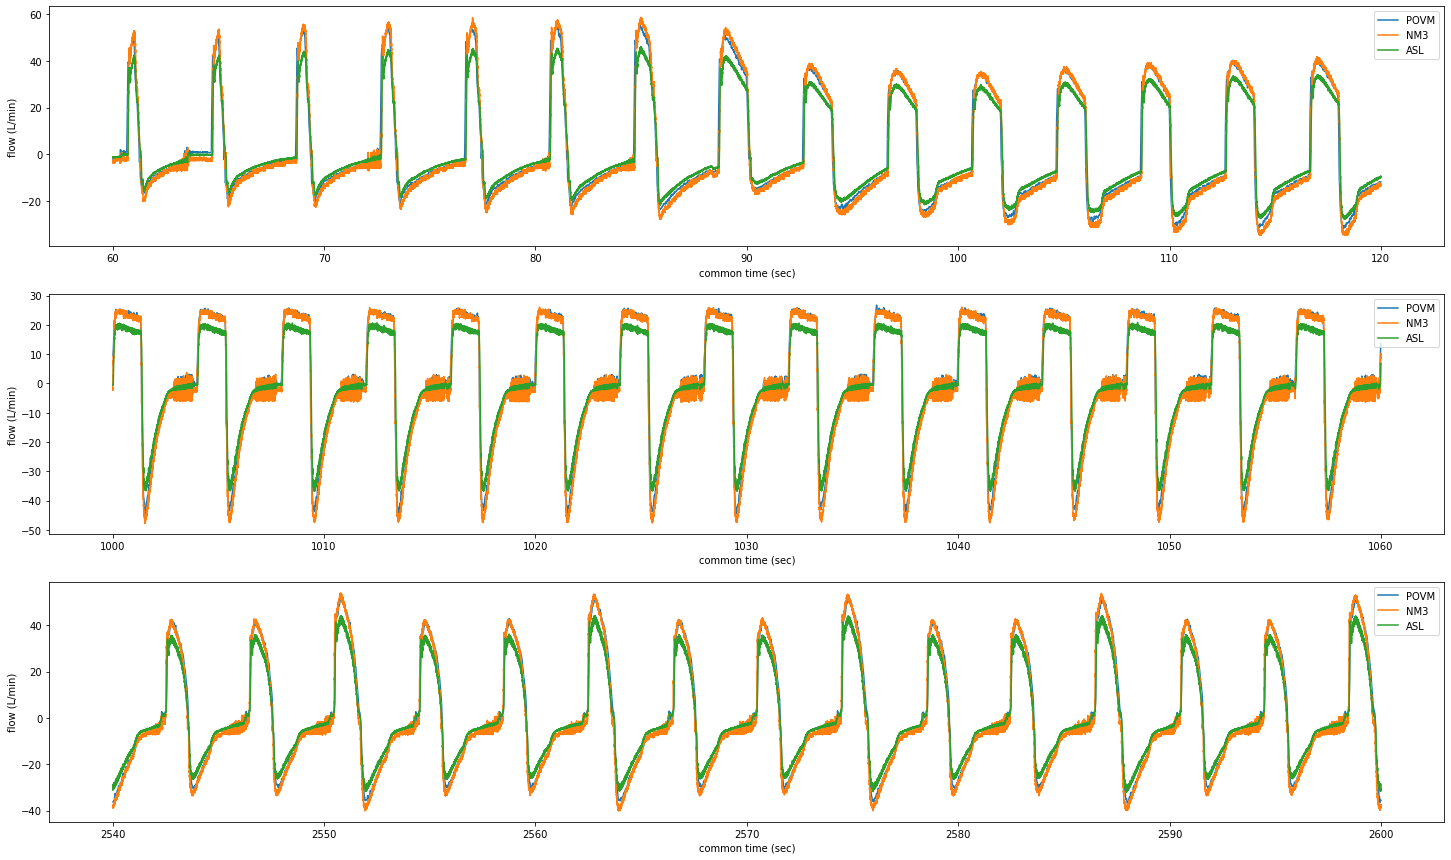

In [10]:
nm3_timeseries["time_shifted"] = nm3_timeseries["time (sec)"] - 39049.6    # tweaked by hand
asl_timeseries["time_shifted"] = asl_timeseries["Time (sec)"] - 1061.8     # tweaked by hand

def plot_in_window(ax, low, high):
    our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "flow (L/min)", ax=ax)
    nm3_timeseries[(low < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax)
    asl_timeseries[(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax)
    ax.legend(["POVM", "NM3", "ASL"], loc="upper right")
    ax.set_ylabel("flow (L/min)")
    ax.set_xlabel("common time (sec)")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
plot_in_window(ax1, 60, 120)
plot_in_window(ax2, 1000, 1060)
plot_in_window(ax3, 2540, 2600)

## Pressure comparisons

These require slight tweaks to the time offset—the flow-measuring and pressure-measuring devices are probably offset in the stream and therefore see features at different times (by a tenth of a second or so).

Of all of ASL's "pressure" measurements, "airway pressure" is the only one that's remotely shaped like what we're measuring (both POVM and NM3).

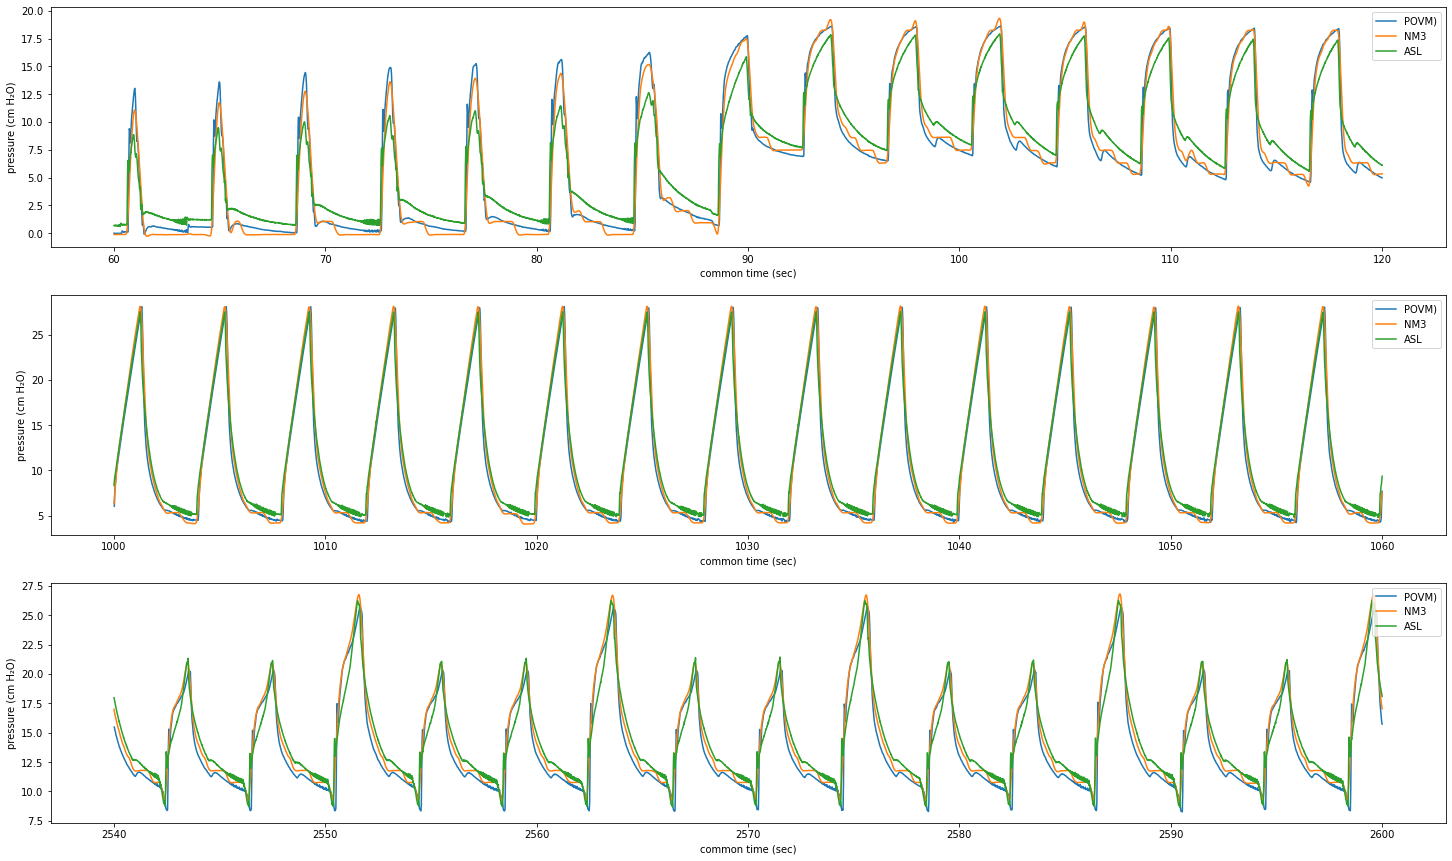

In [11]:
nm3_timeseries["time_shifted_pressure"] = nm3_timeseries["time_shifted"] - 0.2   # tweaked by hand
asl_timeseries["time_shifted_pressure"] = asl_timeseries["time_shifted"] - 0.1   # tweaked by hand

def plot_in_window(ax, low, high):
    our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "pressure (cm H2O)", ax=ax)
    nm3_timeseries[(low < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax)
    asl_timeseries[(low < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax)
    ax.legend(["POVM)", "NM3", "ASL"], loc="upper right")
    ax.set_ylabel("pressure (cm H₂O)")
    ax.set_xlabel("common time (sec)")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
plot_in_window(ax1, 60, 120)
plot_in_window(ax2, 1000, 1060)
plot_in_window(ax3, 2540, 2600)

## Reproducing the flow plot in the paper (to replace it)

I have to find that time range again, and now the common time has a different offset.

This plot should replace the one in the paper because this one is derived from timeseries that were produced by the main codebase, not a random notebook. If we run `device_json_to_timeseries.py` again and re-evaluate this notebook, we can keep the following plot up to date.

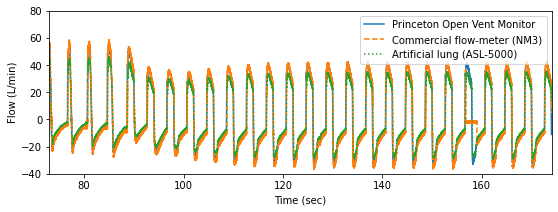

In [12]:
low, high = 73, 174

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "flow (L/min)", ax=ax, linewidth=1.5)
nm3_timeseries[(low < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax, linewidth=1.5, linestyle="--")
asl_timeseries[(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax, linewidth=1.5, linestyle=":")
ax.legend(["Princeton Open Vent Monitor", "Commercial flow-meter (NM3)", "Artificial lung (ASL-5000)"], loc="upper right")
ax.set_ylabel("Flow (L/min)")
ax.set_xlabel("Time (sec)")
ax.set_xlim(low, high)
ax.set_ylim(-40, 80)
fig.savefig("../povm-nm3-asl.pdf")

## Matching time-window for pressure

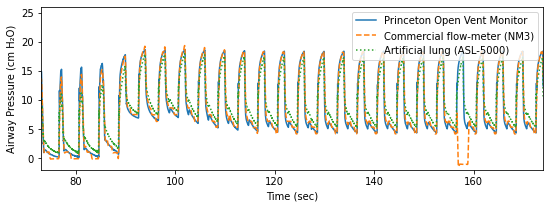

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "pressure (cm H2O)", ax=ax, linewidth=1.5)
nm3_timeseries[(low < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax, linewidth=1.5, linestyle="--")
asl_timeseries[(low < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax, linewidth=1.5, linestyle=":")
ax.legend(["Princeton Open Vent Monitor", "Commercial flow-meter (NM3)", "Artificial lung (ASL-5000)"], loc="upper right")
ax.set_ylabel("Airway Pressure (cm H₂O)")
ax.set_xlabel("Time (sec)")
ax.set_xlim(low, high)
ax.set_ylim(-2, 26)
fig.savefig("../povm-nm3-asl-pressure.pdf")

## Volume vs minbias volume

The "volume" is the volume that we've been showing on the GUI this whole time.

The "minbias volume" is a new calculation that has a 400× lower critical frequency (weaker high-pass filter), and this "minbias volume" is the one that is used to calculate volume _differences_, such as tidal volumes.

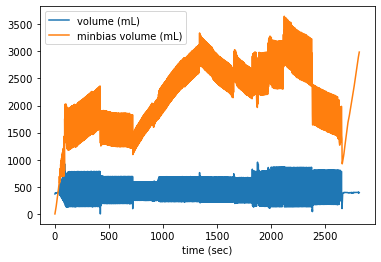

In [14]:
# The minbias volume drifts a lot more, so it's not appropriate to show on the GUI screen, but its shape is less distorted.

our_timeseries.plot("time (sec)", ["volume (mL)", "minbias volume (mL)"])

## Time since first breath in POVM

From Andy:

> Hi @Jim Pivarski Here are three time points i n he video, with mins and seconds elapsed since the first breath (which should be easy to detect on the POVM). I have pulled out derived quantities by reading off the screen of the ventilator in the video. The first point is for the ventulator under volume control. This is very regular.. each breath is the same. The second two time points are from synchronized pressure control. This one has variability in tidal volume and PIP from one breath to the next, so it may be harder to compare.
> 
> 1:50 s in video is first breath of ventilator.. should be first breath in recording
> 0m 0 s post first breath
> 
> 23 m 04 s in Video
> 21 m 14 s post first breath: under volume control; PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm
> 
> 37 m 45 s in Video
> 35 m 55 s post first breath: under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 16 cmH20 [jumps back and forth between 23ish and 16ish]; TVexp 527 [jummps back and forth between 530ish and 700 ish3] ml; RR not reported.
> 
> 40m 32s in Video
> 38m 42s post first breath:  under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 21 cmH20; TVexp 507ml; RR not reported (edited) 
> 
> 9:30
> could you see what the values are that the POVM reports for these time points/

It looks like the "first breath" is at 40 seconds in the common time used by this analysis. There's 1‒2 seconds of uncertainty about what that means, and we could be off by one breath or so.

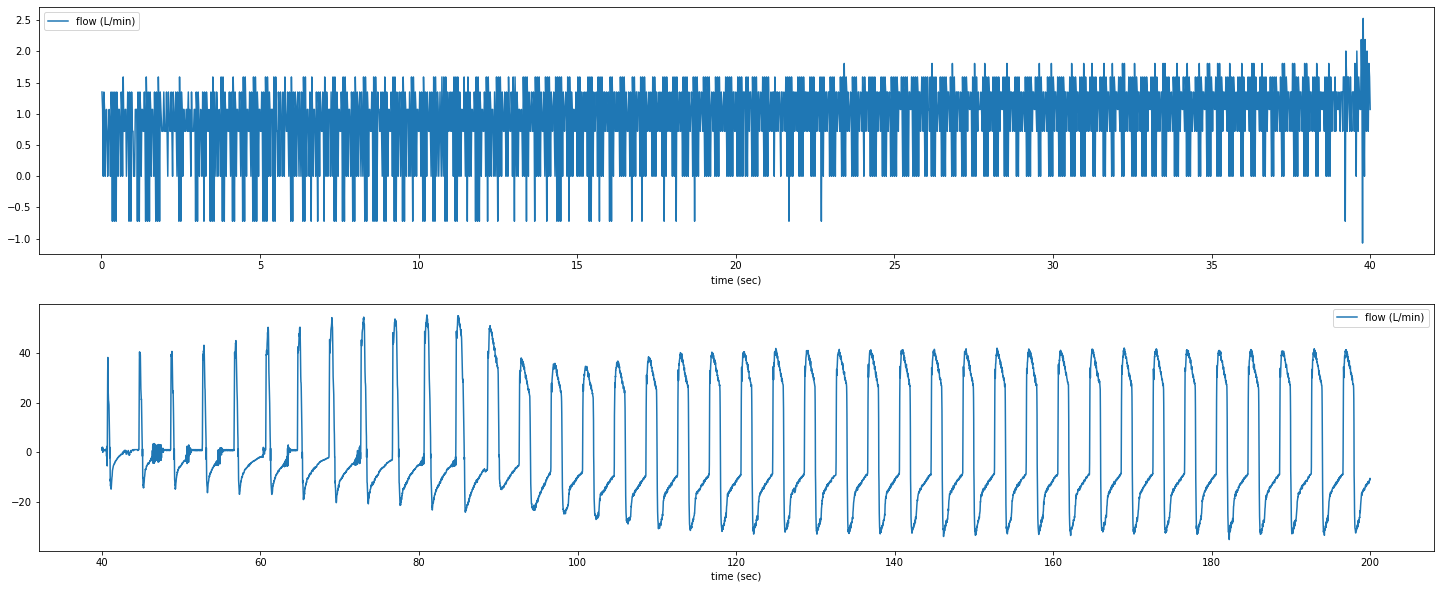

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
our_timeseries[(0 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < 40)].plot("time (sec)", "flow (L/min)", ax=ax1)
our_timeseries[(40 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < 200)].plot("time (sec)", "flow (L/min)", ax=ax2)

In [16]:
our_breaths.iloc[:10]

,inhale timestamp (sec),inhale flow (L/min),inhale dV/dt (mL/sec),inhale dP/dt (cm H2O/sec),inhale compliance (ml/cm H2O),min pressure (cm H2O),full timestamp (sec),full pressure (cm H2O),full volume (mL),expiratory tidal volume (mL),...,exhale dP/dT (cm H2O/sec),exhale compliance (ml/cm H2O),max pressure (cm H2O),empty timestamp (sec),empty pressure (cm H2O),empty volume (mL),exhale time (sec),average flow (L/min),average pressure (cm H2O),time since last (sec)
0,40.764000,38.2733,163.159314,2.580221,63.234627,NaN,41.044000,0.5228,692.9103,NaN,...,-0.878237,147.122343,7.8072,43.064500,-0.4899,574.6538,2.020500,NaN,NaN,NaN
1,44.825000,38.1687,316.186431,4.670678,67.696052,-1.1120,45.185000,-1.3128,755.6194,180.9656,...,-0.342405,392.116560,8.4128,47.136022,-0.1962,631.7116,1.951022,0.906199,0.196794,4.071522
2,48.847044,40.7215,337.888723,3.662988,92.244006,-0.5340,49.187067,-0.7789,831.5861,199.8745,...,-1.212890,121.931272,9.2216,51.109000,0.0976,668.8842,1.921933,0.620322,0.562194,3.972978
3,52.869078,43.1976,389.210240,1.829615,212.727945,-0.2836,53.229844,-0.4096,907.1877,238.3035,...,-1.651000,102.582467,10.3067,55.114300,0.4189,717.9717,1.884456,0.813191,0.930084,4.005300
4,56.876000,43.4641,432.391585,5.874595,73.603647,-0.0544,57.256000,0.1094,982.8826,264.9109,...,-1.587964,119.286326,11.2895,60.316000,-0.0371,695.2333,3.060000,-0.185043,0.988817,5.201700
5,60.916433,46.8591,543.319211,7.015952,77.440554,-0.0576,61.336900,1.2276,1023.6924,328.4591,...,-1.914783,107.668507,13.0307,63.697000,0.6047,736.1643,2.360100,0.782698,1.914427,3.381000
6,64.917000,46.8771,561.391387,4.802724,116.890199,0.0558,65.337000,2.3766,1089.0791,352.9148,...,-2.076558,109.386032,13.6087,68.401000,0.0685,711.1772,3.064000,-0.223140,1.660935,4.704000
7,68.961000,51.3474,658.059136,5.487755,119.914093,0.0330,69.421000,1.9498,1123.0532,411.8760,...,-2.609470,94.471943,14.4498,72.381144,0.1330,711.1736,2.960144,0.079764,2.313437,3.980144
8,72.981833,53.1175,702.020345,4.497520,156.090531,0.1141,73.442111,3.0334,1169.8626,458.6890,...,-2.749520,94.312608,14.9065,76.404911,0.2165,714.1760,2.962800,0.131914,2.665732,4.023767
9,76.985967,53.8166,731.663634,9.339170,78.343541,0.1645,77.486056,3.7043,1205.3174,491.1414,...,-2.706283,104.932276,15.2562,80.410033,0.3425,709.1675,2.923978,0.018743,2.975440,4.005122


In [17]:
asl_timeseries["volume (mL)"] = asl_timeseries["Total Volume (L)"] * 1000

In [18]:
our_breaths["PIP"] = our_breaths["max pressure (cm H2O)"]
our_breaths["PEEP"] = our_breaths["empty pressure (cm H2O)"]
our_breaths["TVi"] = our_breaths["inspiratory tidal volume (mL)"]
our_breaths["TVe"] = our_breaths["expiratory tidal volume (mL)"]
our_breaths["I:E"] = our_breaths["inhale time (sec)"] / our_breaths["exhale time (sec)"]
our_breaths["RR"] = 60 / our_breaths["time since last (sec)"]

In [19]:
def plot_everything(central_value):
    our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["exhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["full timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["empty timestamp (sec)"])) &
                                       ((our_breaths["inhale timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["exhale timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["full timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["empty timestamp (sec)"] < central_value + 10))]

    our_timeseries["volume_shifted"] = our_timeseries["volume (mL)"] - np.min(our_timeseries["volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)])
    our_timeseries["minbias_volume_shifted"] = our_timeseries["minbias volume (mL)"] - np.min(our_timeseries["minbias volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)])
    asl_timeseries["volume_shifted"] = asl_timeseries["volume (mL)"] - np.min(asl_timeseries["volume (mL)"][(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)])
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "volume_shifted", ax=ax1, label="POVM")
    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "minbias_volume_shifted", ax=ax1, label="POVM minbias")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)].plot("time_shifted", "volume_shifted", ax=ax1, linewidth=1.5, linestyle=":", label="ASL")

    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "flow (L/min)", ax=ax2, linewidth=1.5, label="POVM")
    nm3_timeseries[(central_value - 10 < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < central_value + 10)].plot("time_shifted", "flow (L/min)", ax=ax2, linewidth=1.5, linestyle="--", label="NM3")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)].plot("time_shifted", "flow (L/min)", ax=ax2, linewidth=1.5, linestyle=":", label="ASL")

    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "pressure (cm H2O)", ax=ax3, linewidth=1.5, label="POVM")
    nm3_timeseries[(central_value - 10 < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < central_value + 10)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax3, linewidth=1.5, linestyle="--", label="NM3")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < central_value + 10)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax3, linewidth=1.5, linestyle=":", label="ASL")

    for i in range(len(our_breaths_relevant)):
        for ax in (ax1, ax2, ax3):
            ax.axvline(our_breaths_relevant["full timestamp (sec)"].values[i], c="red")
            ax.axvline(our_breaths_relevant["exhale timestamp (sec)"].values[i], c="orange")
            ax.axvline(our_breaths_relevant["empty timestamp (sec)"].values[i], c="green")
    ax1.grid(axis="y")
    ax2.grid(axis="y")
    ax3.grid(axis="y")
#     ax1.set_ylim(0, 1000)
    ax2.set_ylim(-50, 60)
    ax3.set_ylim(0, 40)
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    ax3.legend(loc="upper right")
    ax1.set_xlabel("time (sec)")
    ax2.set_xlabel("time (sec)")
    ax3.set_xlabel("time (sec)")
    ax1.set_ylabel("volume (mL)")
    ax2.set_ylabel("flow (L/min)")
    ax3.set_ylabel("pressure (cm H₂O)")

    return our_breaths_relevant[["PIP", "PEEP", "TVi", "TVe", "I:E", "RR"]]

In [20]:
def plot_volumes(central_value, scale):
    our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["exhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["full timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["empty timestamp (sec)"])) &
                                       ((our_breaths["inhale timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["exhale timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["full timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["empty timestamp (sec)"] < central_value + 10))]

    our_timeseries["volume_shifted"] = our_timeseries["volume (mL)"] - np.min(our_timeseries["volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)])
    our_timeseries["minbias_volume_shifted"] = our_timeseries["minbias volume (mL)"] - np.min(our_timeseries["minbias volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)])
    asl_timeseries["volume_shifted"] = scale * (asl_timeseries["volume (mL)"] - np.min(asl_timeseries["volume (mL)"][(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)]))
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(16, 4))
    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "volume_shifted", ax=ax1, label="POVM")
    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "minbias_volume_shifted", ax=ax1, label="POVM minbias")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)].plot("time_shifted", "volume_shifted", ax=ax1, linewidth=1.5, linestyle=":", label=f"ASL \u00d7 {scale:.1f}")

    ax1.grid(axis="y")
    ax1.legend(loc="upper right")
    ax1.set_xlabel("time (sec)")
    ax1.set_ylabel("volume (mL)")

### First comparison

> 23 m 04 s in Video 21 m 14 s post first breath: under volume control; PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm

,PIP,PEEP,TVi,TVe,I:E,RR
316,28.0216,4.4367,495.8436,501.0093,0.671195,14.944622
317,27.9562,4.5060,501.5202,506.4663,0.667685,14.983768
318,28.0412,4.5493,485.5947,493.5965,0.661602,15.045722
319,28.0105,4.5729,491.7990,494.3090,0.666667,15.000000
320,28.0239,4.4430,487.5793,493.8511,0.664167,15.022534


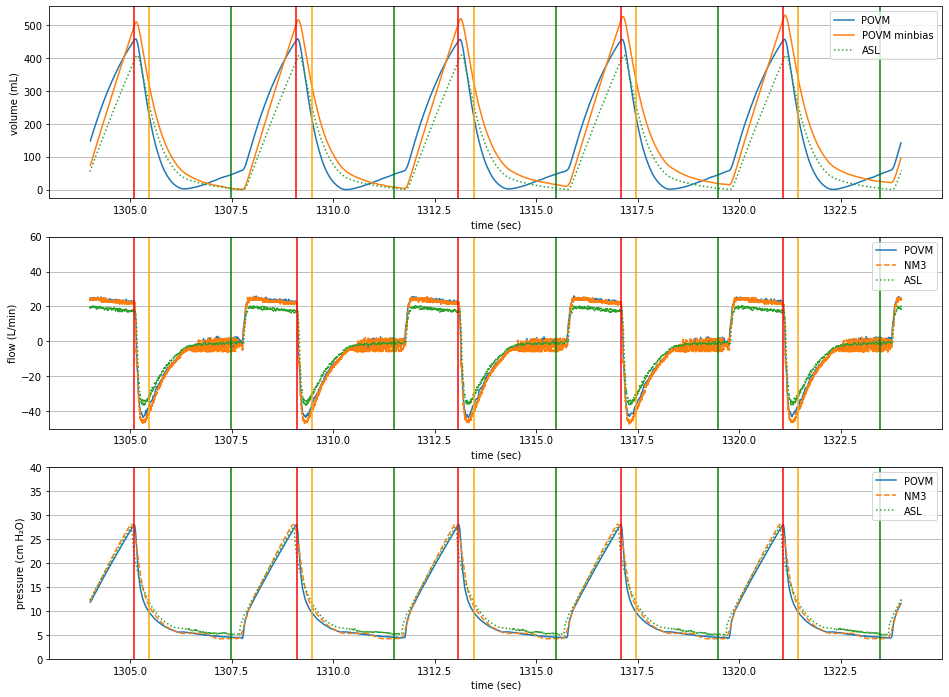

In [21]:
plot_everything(40 + 21*60 + 14)

In [22]:
central_value = 40 + 21*60 + 14

our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"]) |
                                    (central_value - 10 < our_breaths["exhale timestamp (sec)"]) |
                                    (central_value - 10 < our_breaths["full timestamp (sec)"]) |
                                    (central_value - 10 < our_breaths["empty timestamp (sec)"])) &
                                   ((our_breaths["inhale timestamp (sec)"] < central_value + 10) |
                                    (our_breaths["exhale timestamp (sec)"] < central_value + 10) |
                                    (our_breaths["full timestamp (sec)"] < central_value + 10) |
                                    (our_breaths["empty timestamp (sec)"] < central_value + 10))]

our_breaths_relevant[["PIP", "PEEP", "TVi", "TVe", "I:E", "RR"]].mean()

PIP      28.010680
PEEP      4.501580
TVi     492.467360
TVe     497.846440
I:E       0.666263
RR       14.999329
dtype: float64

**expecting** PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm

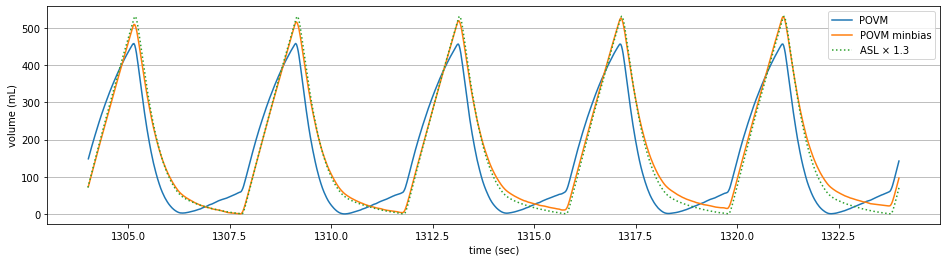

In [23]:
plot_volumes(40 + 21*60 + 14, 1.3)

### Second comparison

> 37 m 45 s in Video
> 35 m 55 s post first breath: under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 16 cmH20 [jumps back and forth between 23ish and 16ish]; TVexp 527 [jummps back and forth between 530ish and 700 ish3] ml; RR not reported.

,PIP,PEEP,TVi,TVe,I:E,RR
562,20.1127,10.1422,612.7479,591.0320,0.506714,15.044297
563,24.3423,10.0169,782.6194,874.2153,0.629615,14.581589
564,20.1135,10.2146,606.2454,525.5855,0.466824,15.345661
565,20.1229,10.1303,614.8169,593.3606,0.500270,15.074493
566,24.3353,10.0973,773.2177,866.0878,0.627279,14.602646


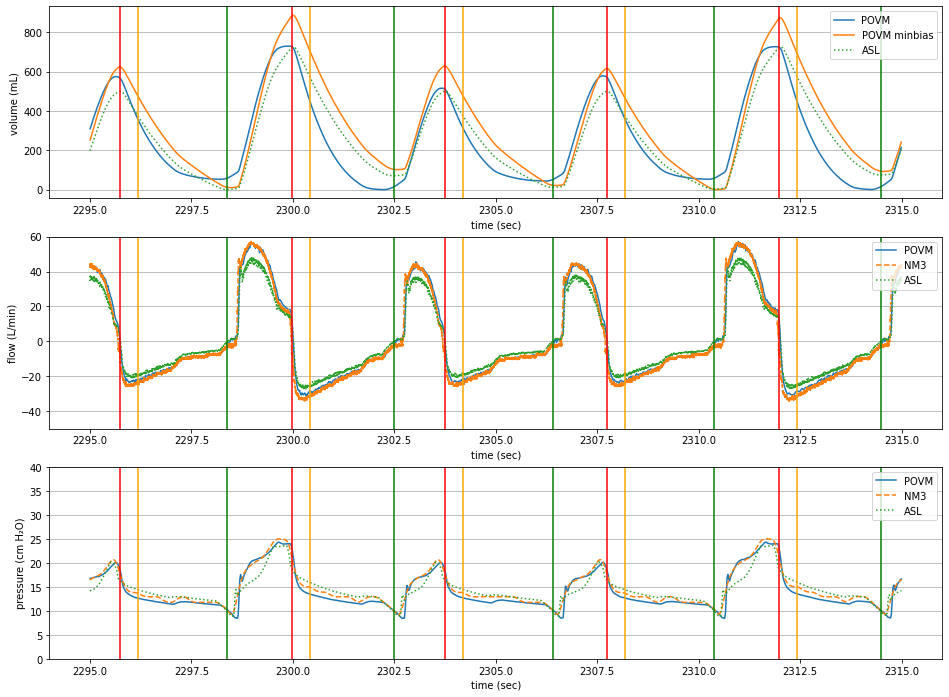

In [24]:
plot_everything(40 + 37*60 + 45)

### Third comparison

> 40m 32s in Video
> 38m 42s post first breath:  under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 21 cmH20; TVexp 507ml; RR not reported

In [ ]:
plot_everything(40 + 38*60 + 42)

,PIP,PEEP,TVi,TVe,I:E,RR
576,20.1379,10.0894,610.8231,528.3027,0.465633,15.355567
577,20.1229,10.0933,617.1609,594.8483,0.506612,15.056378
578,24.3447,9.9508,782.2156,872.5148,0.627478,14.622931
579,20.1300,10.1122,609.9138,524.7917,0.465388,15.326453
580,20.1355,10.1650,619.0259,594.3646,0.500132,15.079039
581,24.3549,10.0540,786.3286,875.1132,0.626096,14.617390
